### load libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### join all venue data

In [57]:
data_1 = pd.read_excel('../01-Data/00-GoogleData/BusinessData_1.xlsx')
data_2 = pd.read_excel('../01-Data/00-GoogleData/BusinessData_2.xlsx')
data_3 = pd.read_excel('../01-Data/00-GoogleData/BusinessData_3.xlsx')

In [58]:
data_1.drop('index', axis=1, inplace=True)
data_2.drop('index', axis=1, inplace=True)
df = pd.concat([data_1,data_2,data_3])

### visualize all venue locations

<Figure size 864x1080 with 0 Axes>

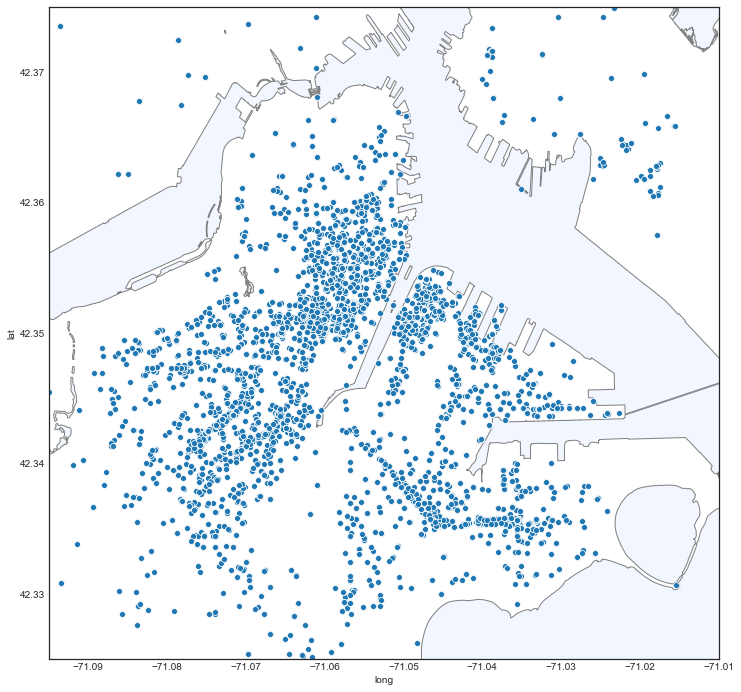

In [59]:
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps

#read shapefiles
shapefile_path = '../01-Data/01-Shapefiles/Hydrography_Polygon.shp'
building_shapefile_path = '../01-Data/01-Shapefiles/boston_buildings.shp'
shapefile = gpd.read_file(shapefile_path)
building_shapefile = gpd.read_file(building_shapefile_path)

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'}) 

##
##plot venue locations
##

plt.figure(figsize=(12,15),facecolor='white')
plt.style.use('seaborn-white')
f, ax = plt.subplots(1, figsize=(12,12))

#define plot ranges
x_min = -71.095
x_max = -71.01
y_min = 42.325
y_max = 42.375
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

#plot
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')
sns.scatterplot(x='long',y='lat', data=df)

In [60]:
df.head()

,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals,mapped_venue_type
0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance
1,"Barclay Damon, LLP",42.352321,-71.056248,ChIJD75e1YBw44kRvDZoMEj44jY,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance
2,Request Health Corporation,42.351584,-71.056269,ChIJv1J9rnh644kR4hc29XVaEFg,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance
3,StackUp,42.351586,-71.056323,ChIJY_v-pXh744kRub1hj4RNwkk,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance
4,KPMG,42.351781,-71.056737,ChIJDaRRe4Jw44kRjXWBXIsFgj0,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance


### Assign Neighborhood

In [61]:
from keras.models import model_from_json
from sklearn.externals import joblib
#assign scaler from file
scaler = joblib.load('NeighborhoodPrediction/coord_scaler.save')

# load json and create model
json_file = open('NeighborhoodPrediction/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("NeighborhoodPrediction/model.best.hdf5")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
prediction_map = {0:'Chinatown',
                  1:'Downtown',
                  2:'Downtown Waterfront',
                  3:'Fort Point',
                  4:'LD/SS',
                  5:'Other',
                  6:'Seaport',
                  7:'South Boston',
                  8:'South End'}

In [64]:
###
###Assign neighborhood locations to Google Data
###

#transform coords
locations = df[['lat','long']].values
locations = scaler.transform(locations)

#make neighborhood predictions
neighborhood = loaded_model.predict(locations)

#assign neighborhood based on softmax probability
n_predictions = []
for item in neighborhood:
    a = list(item)
    i = a.index(max(a))
    n_predictions.append(i)

n_predictions = [prediction_map[i] for i in n_predictions]
df['neighborhood'] = n_predictions
df.head()

,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals,mapped_venue_type,neighborhood
0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance,LD/SS
1,"Barclay Damon, LLP",42.352321,-71.056248,ChIJD75e1YBw44kRvDZoMEj44jY,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance,LD/SS
2,Request Health Corporation,42.351584,-71.056269,ChIJv1J9rnh644kR4hc29XVaEFg,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS
3,StackUp,42.351586,-71.056323,ChIJY_v-pXh744kRub1hj4RNwkk,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS
4,KPMG,42.351781,-71.056737,ChIJDaRRe4Jw44kRjXWBXIsFgj0,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS


<Figure size 864x864 with 0 Axes>

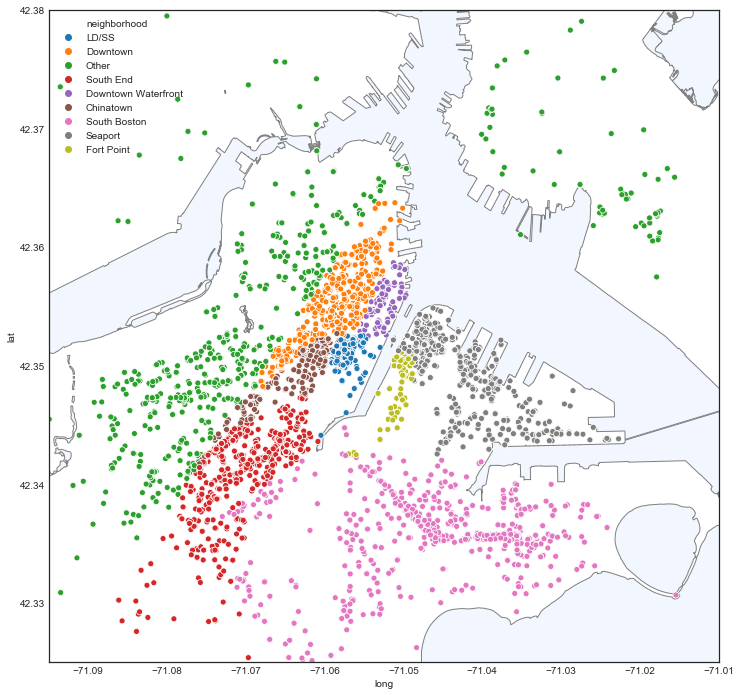

In [221]:
##
##plot venue locations by neighborhood
##

plt.figure(figsize=(12,12),facecolor='white')
plt.style.use('seaborn-white')
f, ax = plt.subplots(1, figsize=(12,12))

#define plot ranges
x_min = -71.095
x_max = -71.01
y_min = 42.325
y_max = 42.38
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

#plot
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')
sns.scatterplot(x='long',y='lat', data=df, hue='neighborhood')
ax.legend(loc='upper left')

### get yelp price rating for each venue

In [158]:
import requests
from bs4 import BeautifulSoup
import json

yelp_client_id = 'Zzqn4E2lPx-0h9PbnYkGgw'
yelp_key = 'BATQ5xWcuvBicxMowK_k1BLIoYOI-1S13eYTRs282i32MK1-vJHQM6Xdf-Qg2x7DhrQbz1LcmN6BXZ-AHZ4UNnXhwPA3Oo-m1-OK-RVPdKlv6TYLlwpwjud2B5KJW3Yx'

prices = []

for i in range(len(df)):
    venue_name = df.iloc[i]['name']
    venue_lat = df.iloc[i]['lat']
    venue_long = df.iloc[i]['long']

    url = "https://api.yelp.com/v3/businesses/search"

    querystring = {"term":venue_name,"latitude":venue_lat,"longitude":venue_long}

    headers = {
        'Authorization': "Bearer {}".format(yelp_key),
        'Cache-Control': "no-cache",
        'Postman-Token': "94cec2cd-fb23-49f6-8c42-9e9753aabeb9"
        }

    venue_data = json.loads(requests.request("GET", url, headers=headers, params=querystring).text)
    
    try:
        yelp_name = venue_data['businesses'][0]['name']
        yelp_price = venue_data['businesses'][0]['price']
    except:
        yelp_price = 'info not available'
    
    if yelp_name == venue_name:
        prices.append(yelp_price)
    else:
        prices.append('info not available')
prices

['info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not available',
 'info not 

In [166]:
prices_adjusted = []
for item in prices:
    if item =="info not available":
        prices_adjusted.append(0)
    elif item == "$":
        prices_adjusted.append(1)
    elif item == "$$":
        prices_adjusted.append(2)
    elif item == "$$$":
        prices_adjusted.append(3)
    elif item == "$$$$":
        prices_adjusted.append(4)
    elif item == "$$$$$":
        prices_adjusted.append(5)
df['price_category'] = prices_adjusted       

<Figure size 864x864 with 0 Axes>

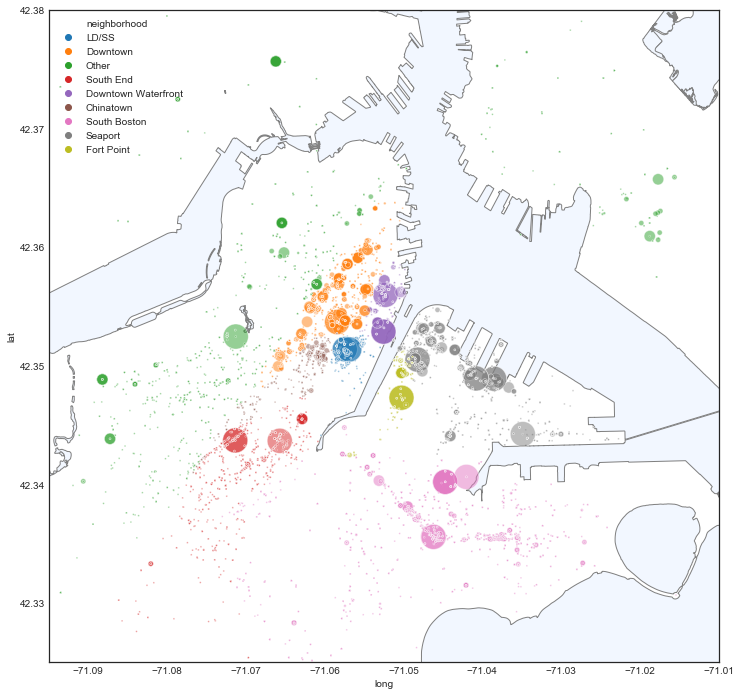

In [219]:
##
##plot venue locations by neighborhood
##

c_pal = ['C0','C1','C6','C2']

plt.figure(figsize=(12,12),facecolor='white')
plt.style.use('seaborn-white')
f, ax = plt.subplots(1, figsize=(12,12))

#define plot ranges
x_min = -71.095
x_max = -71.01
y_min = 42.325
y_max = 42.38
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

s = [2+5**n for n in df['price_category']]

#plot
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')
sns.scatterplot(x='long',y='lat', data=df, hue='neighborhood',s=s,alpha=.5)
ax.legend(loc='upper left')

In [209]:
df.head()

,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals,mapped_venue_type,neighborhood,price_category
0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance,LD/SS,0
1,"Barclay Damon, LLP",42.352321,-71.056248,ChIJD75e1YBw44kRvDZoMEj44jY,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance,LD/SS,0
2,Request Health Corporation,42.351584,-71.056269,ChIJv1J9rnh644kR4hc29XVaEFg,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS,0
3,StackUp,42.351586,-71.056323,ChIJY_v-pXh744kRub1hj4RNwkk,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS,0
4,KPMG,42.351781,-71.056737,ChIJDaRRe4Jw44kRjXWBXIsFgj0,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS,0


### save full dataset to file

In [211]:
df.to_excel('../01-Data/00-GoogleData/180831_venue_data.xlsx')

### load in data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_excel('../01-Data/00-GoogleData/180831_venue_data.xlsx')

In [4]:
df.head(1)

,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals,mapped_venue_type,neighborhood,price_category
0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance,LD/SS,0


In [124]:
def count_type_in_neighborhood():
    from area import area
    #generate lists of neighborhoods and venue types from dataframe
    neighborhoods = [neighborhood for neighborhood in set(df['neighborhood'].values)]
    venue_types = [venue_type for venue_type in set(df['mapped_venue_type'].values)]
    #initialize counts dictionary
    total_counts = {}
    total_per_area_unit_counts = {}
    #iterate through dataframe and save venue type counts per neighborhood
    for neighborhood in neighborhoods:
        n_counts = {}
        per_area_unit_counts = {}
        
        neighborhood_venues = df[df['neighborhood'] == neighborhood]
        
        lat = neighborhood_venues['lat'].values
        long = neighborhood_venues['long'].values
        coords = [[lat[i],long[i]] for i in range(len(neighborhood_venues))]
        
        n_obj = {'type':'Polygon', 'coordinates':[[coord for coord in coords]]}
        
        n_area = area(n_obj) * 0.0000003861022 #convert to square miles
        
        for venue_type in venue_types:
            venues = neighborhood_venues[neighborhood_venues['mapped_venue_type']== venue_type]           
            n_counts[venue_type] = len(venues)
            per_area_unit_counts[venue_type] = len(venues)/n_area
            
        total_counts[neighborhood] = n_counts
        total_per_area_unit_counts[neighborhood] = per_area_unit_counts
        
    return total_counts, total_per_area_unit_counts

In [125]:
total_counts, per_sq_mile = count_type_in_neighborhood()
df_venue_count = pd.DataFrame(total_counts)
df_venue_density = pd.DataFrame(per_sq_mile)

In [1]:
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(20,10))

linewidth =0.15

scaler = MinMaxScaler()
scaler.fit(df_venue_density)

density_norm_by_neighborhood = pd.DataFrame(scaler.transform(df_venue_density), columns=df_venue_density.columns)
density_norm_by_neighborhood.index = df_venue_density.index

df_venue_density_transpose = df_venue_density.transpose()
scaler.fit(df_venue_density_transpose)
density_norm_by_venue_type = pd.DataFrame(scaler.transform(df_venue_density_transpose), columns=df_venue_density_transpose.columns)
density_norm_by_venue_type.index = df_venue_density_transpose.index
density_norm_by_venue_type = density_norm_by_venue_type.transpose()

plt.subplot(1,2,1)
sns.heatmap(density_norm_by_venue_type,linewidths=linewidth)
plt.title('Venue Density by Neighborhood (read accross)')

plt.subplot(1,2,2)
sns.heatmap(density_norm,linewidths=linewidth)
plt.title('Neighborhood Density by Venue (read down)')

NameError: name 'plt' is not defined

In [208]:
type_count_in_neighborhood = list()
type_density_in_neighborhood = list()
for i in range(len(df)):
    neighborhood = df.iloc[i]['neighborhood']
    venue_type = df.iloc[i]['mapped_venue_type']
    count = total_counts[neighborhood][venue_type]
    density = per_sq_mile[neighborhood][venue_type]
    type_count_in_neighborhood.append(count)
    type_density_in_neighborhood.append(density)
df['type_count_in_neighborhood'] = type_count_in_neighborhood
df['type_density_in_neighborhood'] = [round(density,2) for density in type_density_in_neighborhood]
df.head()

,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals,mapped_venue_type,neighborhood,price_category,type_count_in_neighborhood,type_density_in_neighborhood
0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83
1,"Barclay Damon, LLP",42.352321,-71.056248,ChIJD75e1YBw44kRvDZoMEj44jY,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83
2,Request Health Corporation,42.351584,-71.056269,ChIJv1J9rnh644kR4hc29XVaEFg,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83
3,StackUp,42.351586,-71.056323,ChIJY_v-pXh744kRub1hj4RNwkk,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83
4,KPMG,42.351781,-71.056737,ChIJDaRRe4Jw44kRjXWBXIsFgj0,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83


### save full dataset to file

In [209]:
df.to_excel('../01-Data/00-GoogleData/180904_venue_data.xlsx')

### load in data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_excel('../01-Data/00-GoogleData/180904_venue_data.xlsx')

In [3]:
df.head()

,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,WeekTotals,mapped_venue_type,neighborhood,price_category,type_count_in_neighborhood,type_density_in_neighborhood
0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83
1,"Barclay Damon, LLP",42.352321,-71.056248,ChIJD75e1YBw44kRvDZoMEj44jY,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83
2,Request Health Corporation,42.351584,-71.056269,ChIJv1J9rnh644kR4hc29XVaEFg,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83
3,StackUp,42.351586,-71.056323,ChIJY_v-pXh744kRub1hj4RNwkk,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83
4,KPMG,42.351781,-71.056737,ChIJDaRRe4Jw44kRjXWBXIsFgj0,"['accounting', 'finance', 'point_of_interest',...",0,0,0,0,0,0,0,0,finance,LD/SS,0,27,235.83


In [80]:
import requests
walkscore_api = '13bb67a555b0472558b94c607a6525a9'

walk_score = list()
transit_score = list()
transit_summary = list()
bike_score = list()

for i in range(len(df)):

    address = ""
    lat = df.iloc[i]['lat']
    long = df.iloc[i]['long']

    url = 'http://api.walkscore.com/score?format=json&address={}&lat={}&lon={}&transit=1&bike=1&wsapikey={}'.format(address,lat,long,walkscore_api)

    response = requests.get(url)
    response = response.json()
    
    try:
        walk_score.append(response['walkscore'])
    except:
        walk_score.append(np.nan)
    try:
        transit_score.append(response['transit']['score'])
        transit_summary.append(response['transit']['summary'])
    except:
        transit_score.append(np.nan)
        transit_summary.append('no information available')
    try:
        bike_score.append(response['bike']['score'])
    except:
        bike_score.append(np.nan)
    
df['walk_score'] = walk_score
df['transit_score'] = transit_score
df['bike_score'] = bike_score
df['transit_summary'] = transit_summary


df.head(2)

,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,...,mapped_venue_type,neighborhood,price_category,type_count_in_neighborhood,type_density_in_neighborhood,visit_venue_density,walk_score,transit_score,bike_score,transit_summary
0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,...,finance,LD/SS,0,27,235.83,0.0,98.0,100.0,82.0,"78 nearby routes: 50 bus, 16 rail, 12 other"
1,"Barclay Damon, LLP",42.352321,-71.056248,ChIJD75e1YBw44kRvDZoMEj44jY,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,...,finance,LD/SS,0,27,235.83,0.0,98.0,100.0,82.0,"78 nearby routes: 50 bus, 16 rail, 12 other"


In [135]:
df['average_walk_score'] = (df['walk_score']+df['transit_score']+df['bike_score'])/3
df.head(2)

,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,Friday,...,neighborhood,price_category,type_count_in_neighborhood,type_density_in_neighborhood,visit_venue_density,walk_score,transit_score,bike_score,transit_summary,average_walk_score
0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,...,LD/SS,0,27,235.83,0.0,98.0,100.0,82.0,"78 nearby routes: 50 bus, 16 rail, 12 other",93.333333
1,"Barclay Damon, LLP",42.352321,-71.056248,ChIJD75e1YBw44kRvDZoMEj44jY,"['accounting', 'lawyer', 'finance', 'point_of_...",0,0,0,0,0,...,LD/SS,0,27,235.83,0.0,98.0,100.0,82.0,"78 nearby routes: 50 bus, 16 rail, 12 other",93.333333


<Figure size 1080x1080 with 0 Axes>

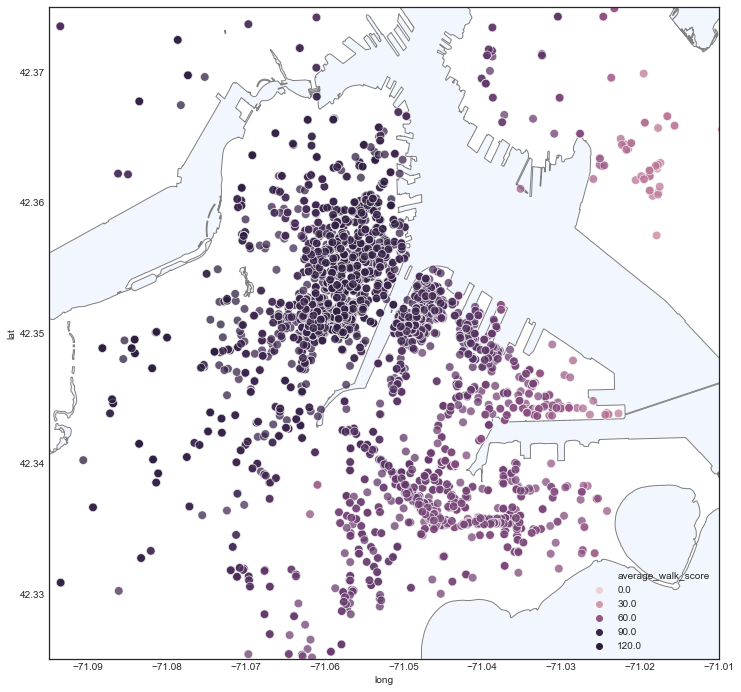

In [152]:
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps

#read shapefiles
shapefile_path = '../01-Data/01-Shapefiles/Hydrography_Polygon.shp'
building_shapefile_path = '../01-Data/01-Shapefiles/boston_buildings.shp'
shapefile = gpd.read_file(shapefile_path)
building_shapefile = gpd.read_file(building_shapefile_path)

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'}) 

##
##plot venue locations
##

plt.figure(figsize=(15,15),facecolor='white')
plt.style.use('seaborn-white')
f, ax = plt.subplots(1, figsize=(12,12))

#define plot ranges
x_min = -71.095
x_max = -71.01
y_min = 42.325
y_max = 42.375
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
                                                                              
#plot
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')
sns.scatterplot(x='long',y='lat', data=df, s=75,hue='average_walk_score',alpha=.75)

<IPython.core.display.Javascript object>


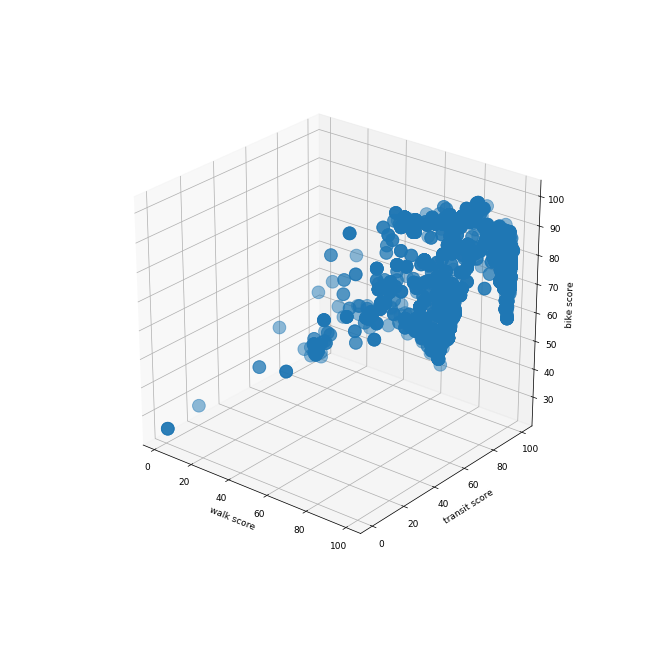

Text(0.5,0,'bike score')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%matplotlib notebook 

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

#%matplotlib inline

#%matplotlib qt

X, Y, Z = df['walk_score'], df['transit_score'], df['bike_score']
#c = ['C1','C2']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


#ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
#for c in color:
ax.scatter3D(X, Y, Z, alpha=0.5, s=200,cmap=cm.coolwarm)
    
ax.set_xlabel('walk score')
ax.set_ylabel('transit score')
ax.set_zlabel('bike score')


### save dataset to file

In [220]:
df.to_excel('../01-Data/00-GoogleData/180905_venue_data.xlsx')

### load in 180905 dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_excel('../01-Data/00-GoogleData/180905_venue_data.xlsx')

In [42]:
import requests
import json

walk_score_api = "12605481a4f328f8c9051ce88dae7625"
lat = 42.349822
long = -71.058572
mode = 'walk'
precision = 5
congestion = 1

times = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

for time in times:

    url = 'http://api2.walkscore.com/api/v1/traveltime_polygon/json?wsapikey={}&origin={}%2C{}&mode={}&time={}&precision={}&congestion={}'.format(walk_score_api, lat, long, mode, time,precision,congestion)

    response = requests.get(url)
    response = response.json()
    
    walk_boundary = response['response']['geometry']['coordinates'][0][0]
    obj = {'type':'Polygon', 'coordinates':[[coord for coord in walk_boundary]]}
    
    filename = '../01-Data/03-WalkScore_Boundaries/{}_{}_minute.json'.format(mode,time)
    
    with open(filename, 'w') as f:
        json.dump(obj, f)
    
#response

In [43]:
#read shapefiles
shapefile_path = '../01-Data/01-Shapefiles/Hydrography_Polygon.shp'
building_shapefile_path = '../01-Data/01-Shapefiles/boston_buildings.shp'
walktime_shapefile_path = '../01-Data/03-WalkScore_Boundaries/walktimes/POLYGON.shp'
shapefile = gpd.read_file(shapefile_path)
building_shapefile = gpd.read_file(building_shapefile_path)
walktime_shapefile = gpd.read_file(walktime_shapefile_path)

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'})

<Figure size 1080x1080 with 0 Axes>

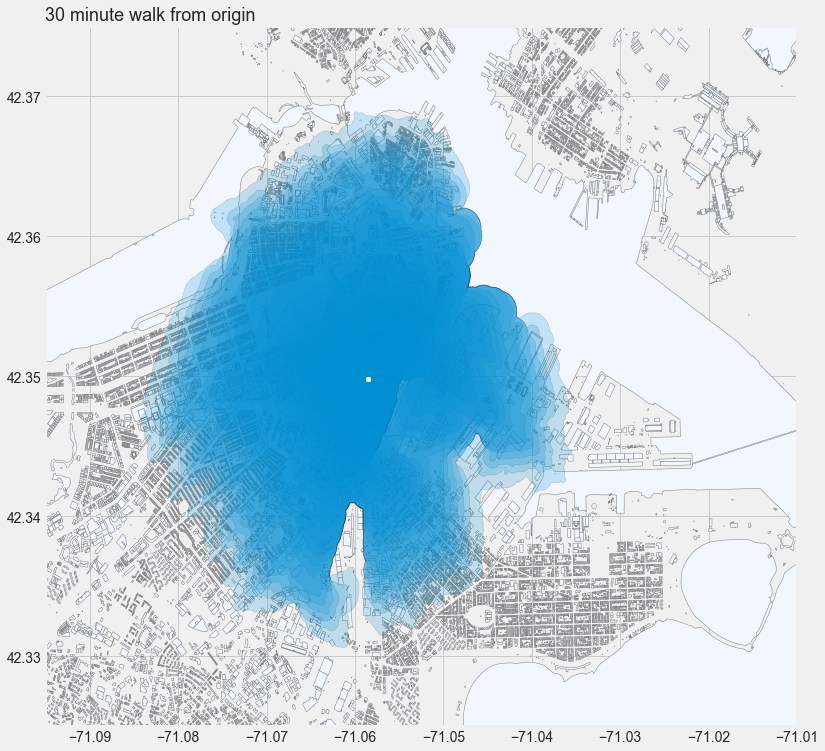

In [82]:
plt.figure(figsize=(15,15),facecolor='white')
plt.style.use('fivethirtyeight')
f, ax = plt.subplots(1, figsize=(12,12))

#define plot ranges
x_min = -71.095
x_max = -71.01
y_min = 42.325
y_max = 42.375
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')
building_shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')

for i in range(len(walktime_shapefile)):
    minute = i+1
    df_i = walktime_shapefile[i:i+1]
    df_i.plot(ax=ax,alpha=0.2, edgecolor='black')
    #df_i.plot(ax=ax,edgecolor='black', )
    sns.scatterplot(x=[-71.058572], y=[42.349822],color='white',size=300)
    ax.legend().remove()
    #plt.text(x=,y=,"{} minute walk from origin".format(i+1))
    ax.set_title("{} minute walk from origin".format(minute),loc='left',size=18)
    plt.savefig('../01-Data/03-WalkScore_Boundaries/frames/walktime_{}.png'.format(i))
    
    


### load in bluebike data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bluebike_raw = pd.read_csv('../01-Data/04-Bluebikes/201807-bluebikes-tripdata.csv')
bluebike_raw

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,220,2018-07-01 00:01:06.5090,2018-07-01 00:04:46.9020,11,Longwood Ave at Binney St,42.338629,-71.106500,45,Jersey St. at Boylston St.,42.344681,-71.097853,1188,Subscriber,1969,0
1,6578,2018-07-01 00:01:12.9890,2018-07-01 01:50:51.8080,26,Washington St at Waltham St,42.341522,-71.068922,26,Washington St at Waltham St,42.341522,-71.068922,2020,Subscriber,1969,0
2,1311,2018-07-01 00:01:18.5470,2018-07-01 00:23:10.1620,20,Aquarium T Stop - 200 Atlantic Ave,42.359912,-71.051430,61,Boylston St at Fairfield St,42.348762,-71.082383,2875,Subscriber,1961,1
3,831,2018-07-01 00:01:26.4870,2018-07-01 00:15:18.3110,116,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,117,Binney St / Sixth St,42.366095,-71.086388,2334,Subscriber,1990,1
4,1318,2018-07-01 00:01:34.4200,2018-07-01 00:23:33.3580,194,Broadway St at Mt Pleasant St,42.386141,-71.078281,100,Davis Square,42.396969,-71.123024,2813,Subscriber,1990,1
5,609,2018-07-01 00:01:40.1220,2018-07-01 00:11:49.9860,75,Lafayette Square at Mass Ave / Main St / Colum...,42.363465,-71.100573,179,MIT Vassar St,42.355601,-71.103945,2152,Subscriber,1993,1
6,523,2018-07-01 00:01:42.1850,2018-07-01 00:10:26.1720,149,175 N Harvard St,42.363796,-71.129164,104,Harvard University Radcliffe Quadrangle at She...,42.380287,-71.125107,49,Subscriber,1973,1
7,564,2018-07-01 00:02:15.3560,2018-07-01 00:11:40.3010,75,Lafayette Square at Mass Ave / Main St / Colum...,42.363465,-71.100573,179,MIT Vassar St,42.355601,-71.103945,3073,Subscriber,1992,2
8,1499,2018-07-01 00:04:03.7160,2018-07-01 00:29:02.9300,71,Conway Park - Somerville Avenue,42.383405,-71.107593,179,MIT Vassar St,42.355601,-71.103945,2046,Subscriber,1994,1
9,1349,2018-07-01 00:04:21.4040,2018-07-01 00:26:50.4830,85,Spaulding Rehabilitation Hospital - Charlestow...,42.378338,-71.048927,60,Charles Circle - Charles St at Cambridge St,42.360185,-71.070866,2551,Subscriber,1992,1


In [4]:
import time
from datetime import datetime

#convert start and end times to unix

start_d = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f') for time in bluebike_raw['starttime']]
stop_d = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f') for time in bluebike_raw['stoptime']]

bluebike_raw['start_unix_time'] = [int(time.mktime(d.timetuple())) for d in start_d]
bluebike_raw['stop_unix_time'] = [int(time.mktime(d.timetuple())) for d in stop_d]

bluebike_raw

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,start_unix_time,stop_unix_time
0,220,2018-07-01 00:01:06.5090,2018-07-01 00:04:46.9020,11,Longwood Ave at Binney St,42.338629,-71.106500,45,Jersey St. at Boylston St.,42.344681,-71.097853,1188,Subscriber,1969,0,1530417666,1530417886
1,6578,2018-07-01 00:01:12.9890,2018-07-01 01:50:51.8080,26,Washington St at Waltham St,42.341522,-71.068922,26,Washington St at Waltham St,42.341522,-71.068922,2020,Subscriber,1969,0,1530417672,1530424251
2,1311,2018-07-01 00:01:18.5470,2018-07-01 00:23:10.1620,20,Aquarium T Stop - 200 Atlantic Ave,42.359912,-71.051430,61,Boylston St at Fairfield St,42.348762,-71.082383,2875,Subscriber,1961,1,1530417678,1530418990
3,831,2018-07-01 00:01:26.4870,2018-07-01 00:15:18.3110,116,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,117,Binney St / Sixth St,42.366095,-71.086388,2334,Subscriber,1990,1,1530417686,1530418518
4,1318,2018-07-01 00:01:34.4200,2018-07-01 00:23:33.3580,194,Broadway St at Mt Pleasant St,42.386141,-71.078281,100,Davis Square,42.396969,-71.123024,2813,Subscriber,1990,1,1530417694,1530419013
5,609,2018-07-01 00:01:40.1220,2018-07-01 00:11:49.9860,75,Lafayette Square at Mass Ave / Main St / Colum...,42.363465,-71.100573,179,MIT Vassar St,42.355601,-71.103945,2152,Subscriber,1993,1,1530417700,1530418309
6,523,2018-07-01 00:01:42.1850,2018-07-01 00:10:26.1720,149,175 N Harvard St,42.363796,-71.129164,104,Harvard University Radcliffe Quadrangle at She...,42.380287,-71.125107,49,Subscriber,1973,1,1530417702,1530418226
7,564,2018-07-01 00:02:15.3560,2018-07-01 00:11:40.3010,75,Lafayette Square at Mass Ave / Main St / Colum...,42.363465,-71.100573,179,MIT Vassar St,42.355601,-71.103945,3073,Subscriber,1992,2,1530417735,1530418300
8,1499,2018-07-01 00:04:03.7160,2018-07-01 00:29:02.9300,71,Conway Park - Somerville Avenue,42.383405,-71.107593,179,MIT Vassar St,42.355601,-71.103945,2046,Subscriber,1994,1,1530417843,1530419342
9,1349,2018-07-01 00:04:21.4040,2018-07-01 00:26:50.4830,85,Spaulding Rehabilitation Hospital - Charlestow...,42.378338,-71.048927,60,Charles Circle - Charles St at Cambridge St,42.360185,-71.070866,2551,Subscriber,1992,1,1530417861,1530419210
